In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# run this code to make sure you install all the required libraries
# be sure you are in virtual environment before install, otherwise it will overwrite your local environment

# !pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option("display.max_columns", None)
RANDOM_SEED = 123

In [5]:
# import necessary assets
import joblib

# train df
train = joblib.load('assets/train.joblib')

# tfidf_matrix
title_en_tfidf_matrix = joblib.load('assets/title_en_tfidf_matrix.joblib')
synopsis_tfidf_matrix = joblib.load('assets/synopsis_tfidf_matrix.joblib')

# tfidf vectorizer
tfidf_title = joblib.load('assets/tfidf_title_vectorizer.joblib')
tfidf_synopsis = joblib.load('assets/tfidf_synopsis_vectorizer.joblib')

# Topic modeling

In [6]:
NUM_OF_TOPIC = 8

## LDA

In [7]:
# combine tfidf title and synopsis together as input of topic modeling
from scipy.sparse import hstack

combined_tfidf_matrix = hstack([title_en_tfidf_matrix, synopsis_tfidf_matrix])

# Combine the feature names from both vectorizers
feature_names_title = tfidf_title.get_feature_names_out().tolist()
feature_names_synopsis = tfidf_synopsis.get_feature_names_out().tolist()
combined_feature_names = feature_names_title + feature_names_synopsis

# mimic the behavior of a single vectorizer for pyLDAvis visualization
class CombinedVectorizer:
    def get_feature_names_out(self):
        return combined_feature_names

In [8]:
# LDA with tfidf title and synopsis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED)
lda_topic_distribution = lda_model.fit_transform(combined_tfidf_matrix)

temp_df = pd.DataFrame(lda_topic_distribution)

# the dominant topic for each document
train['topic_LDA'] = temp_df.idxmax(axis=1)
# the confidence score for each document
train['topic_LDA_score'] = temp_df.max(axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_LDA_score'] = (train['topic_LDA_score'] - train['topic_LDA_score'].min()) / (train['topic_LDA_score'].max() - train['topic_LDA_score'].min())

# visualization
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, combined_tfidf_matrix, CombinedVectorizer(), mds='tsne')
lda_vis

PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
2      -30.529730  80.021797       1        1  23.387092
1       89.042908 -46.920479       2        1  19.614985
3       24.182608 -23.289671       3        1  17.928312
0      102.389328  24.702610       4        1  12.908780
6      -89.539879 -59.093845       5        1  11.159025
7      -31.245966  33.185181       6        1   7.684740
5      -39.773121 -23.422989       7        1   4.064944
4       38.219860  41.940674       8        1   3.252122, topic_info=               Term         Freq        Total Category  logprob  loglift
5387            org  2291.000000  2291.000000  Default  30.0000  30.0000
5631         person  2302.000000  2302.000000  Default  29.0000  29.0000
9936  person person  1365.000000  1365.000000  Default  28.0000  28.0000
9870         person  2734.000000  2734.000000  Default  27.0000  27.0000
9803            org  1880.000000  1880.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
9654            man    12.582893   287.661209   Topic8  -5.7426   0.2964
9803            org    14.814831  1880.990249   Topic8  -5.5793  -1.4181
9475           idol     8.600744    63.203231   Topic8  -6.1231   1.4314
9366            gpe     9.257850   941.138055   Topic8  -6.0495  -1.1958
9590           life     8.782879   408.463112   Topic8  -6.1021  -0.4137

[590 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
88         4  0.815514    actually
8673       1  0.033346  adaptation
8673       2  0.166732  adaptation
8673       3  0.033346  adaptation
8673       6  0.766967  adaptation
...      ...       ...         ...
10644      5  0.125884       young
10644      6  0.003934       young
10644      7  0.015736       young
10644      8  0.019669       young
8641       2  0.902017      zombie

[1374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 7, 8, 6, 5])

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_score_distribution(train, topic_col, score_col, title):
    """
    Function to visualize the distribution of the confidence score for each topic.
    """

    plt.figure(figsize=(10, 8))

    sns.boxplot(x=topic_col, y=score_col, data=train)

    plt.title(f'Distribution of Topic Scores for {title}')
    plt.xlabel('Topic')
    plt.ylabel('Normalized Topic Score')
    plt.xticks(range(NUM_OF_TOPIC), [i for i in range(NUM_OF_TOPIC)])
    
    plt.show()

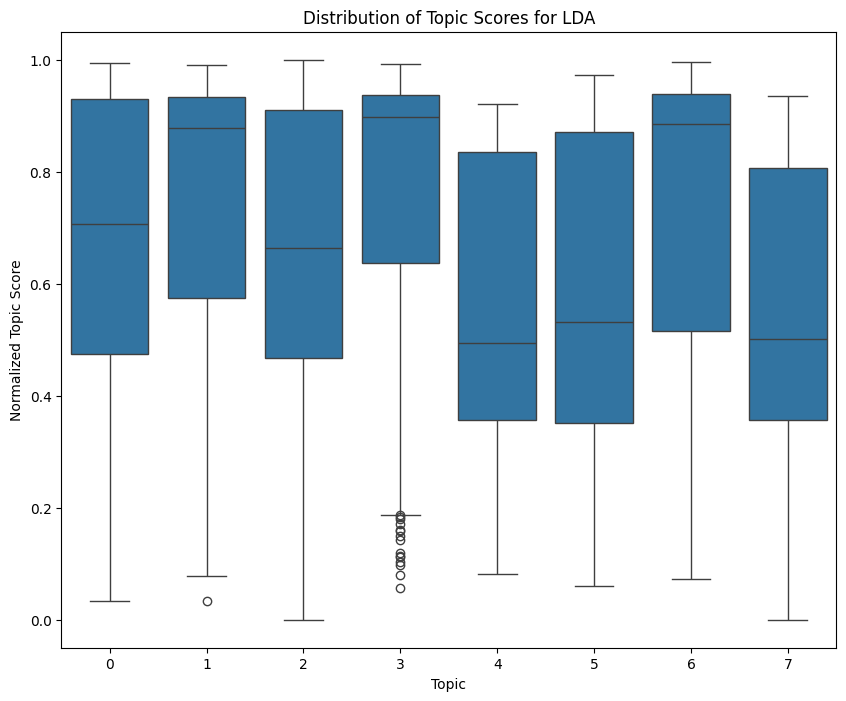

In [10]:
plot_topic_score_distribution(train, 'topic_LDA', 'topic_LDA_score', 'LDA')

In [11]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_LDA']==topic].sort_values('topic_LDA_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['我在仙界挣积分', 'らんま１／２\u3000熱闘歌合戦', 'ろりこんにちは！', '디펜스 게임의 폭군이 되었다', 'ハイスクールD×D BorN', '熊出没之探险日记', '너의 미소가 함정', 'デザートイーグル', '憎らしいほど愛してる', '地球少女アルジュナ', '全职高手', 'キッズキャッスル', '黒の召喚士', 'ロンリーとオーガンジー', '大自然の魔獣 バギ', '家庭教師ヒットマンREBORN! ボンゴレファミリー総登場! ボンゴレ式修学旅行、来る!!', '子連れ狼', 'アンネの日記', 'いいなりのすゝめ', '劇場版 美少女戦士セーラームーンEternal']
topic:  1 
 ['3月のライオン', 'アンドロイドは経験人数に入りますか??', 'きらりん☆レボリューション', 'セラピーゲーム リスタート', 'ナンジャモの相棒は何者なんじゃ!?【ドンナモンジャTV】', 'ましまえん', '自動販売機に生まれ変わった俺は迷宮を彷徨う', 'うずまき', 'いないいないばあば', 'キャップ革命ボトルマン', '움직임의 사전', '姫騎士がクラスメート!', 'わたしのトーチカ', '女生徒', 'ガートルードのレシピ', '栄光のナポレオン - エロイカ', '強制ハーレム契約', '島耕作のアジア立志伝', '恐怖・地獄少女', 'ふしぎの国の有栖川さん']
topic:  2 
 ['トップをねらえ！ GunBuster', '남자주인공의 여자사람친구입니다', '異世界はスマートフォンとともに。', 'へび少女', '킹더랜드', '絶対にときめいてはいけない!', 'スローループ', 'ELDEN RING 黄金樹への道', 'ワンピース\u3000フィルム\u3000\ufeffＺ', 'テラストーリー', 'ワンピース ねじまき島の冒険', 'スキップとローファー', '僕だけのロマンチスト', '青の世界', 'On the Way to a Smile ファイナルファンタジーVII', '聖女二人の異世界ぶらり旅', '絶対衝激～プラトニックハート～', '白魔導師シロップさん', '宇宙ショーへようこそ', 'ピーチガールNEXT']
topic:  3 
 

## NMF

In combining the title and synopsis embeddings for each anime/manga entry, we faced the challenge of differing word lengths. Directly stacking the embeddings could cause imbalance in representing the two sources of information. To address this, we chose to average the embeddings for each entry, allowing us to capture the overall semantic meaning of the entire document without losing the key contextual information. While it does lose some individual word-level granularity, the averaged vector still provides a strong representation of the dominant themes.

In [12]:
train['title_en_skipgram'][0].shape

(4, 300)

In [13]:
train['synopsis_skipgram'][0].shape

(108, 150)

In [14]:
# combine skip-gram title and synopsis together as input of topic modeling

train['combined_embedding'] = train.apply(
    lambda row: np.hstack((
        np.mean(row['title_en_skipgram'], axis=0),
        np.mean(row['synopsis_skipgram'], axis=0)
    ))
    , axis=1
)
train['combined_embedding'][0].shape

(450,)

In [15]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# convert the series into a 2D numpy array
embedding_matrix = np.vstack(train['combined_embedding'].values)

# apply Min-Max Normalization to due with negative value
min_max_scaler = MinMaxScaler()
embedding_matrix_non_negative = min_max_scaler.fit_transform(embedding_matrix)

nmf_model = NMF(n_components=NUM_OF_TOPIC, random_state=RANDOM_SEED, init="nndsvd", max_iter=20000)
nmf_topic_distribution = nmf_model.fit_transform(embedding_matrix_non_negative)

# find the dominant topic for each document
train['topic_nmf'] = np.argmax(nmf_topic_distribution, axis=1)
# the confidence score for each document
train['topic_nmf_score'] = np.max(nmf_topic_distribution, axis=1)
# normalize the confidence scores to range between 0 and 1
train['topic_nmf_score'] = (train['topic_nmf_score'] - train['topic_nmf_score'].min()) / (train['topic_nmf_score'].max() - train['topic_nmf_score'].min())

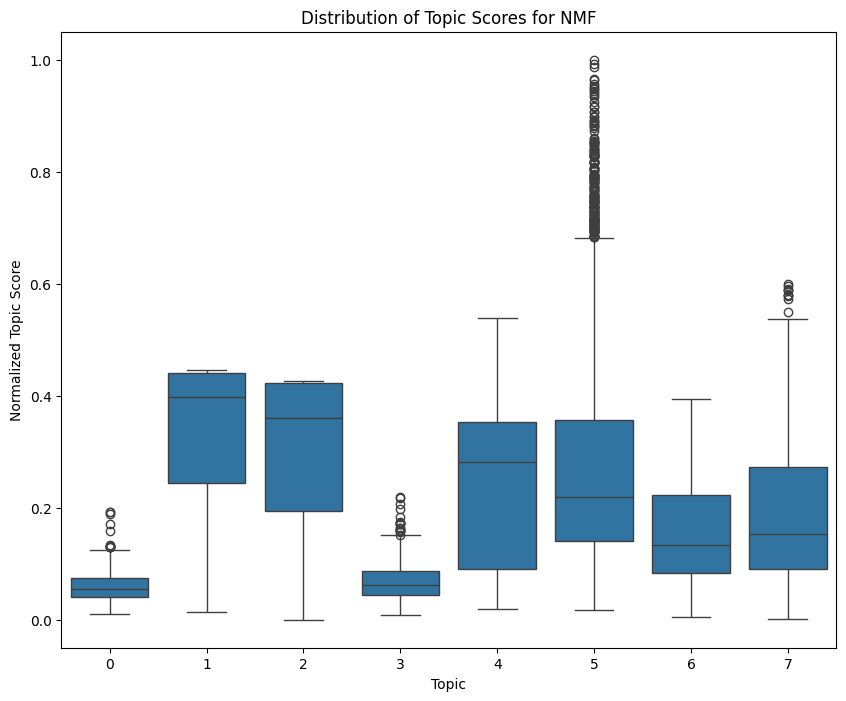

In [16]:
plot_topic_score_distribution(train, 'topic_nmf', 'topic_nmf_score', 'NMF')

In [17]:
# top 20 confidence for each topic
for topic in range(NUM_OF_TOPIC):
    print('topic: ', topic, '\n', train[train['topic_nmf']==topic].sort_values('topic_nmf_score', ascending=False)['title_japanese'].head(20).tolist())

topic:  0 
 ['高野交差点', '村人ですが何か？', 'サバイバル', 'WAVER（ウェーバー）', 'あなたでふくらむ、私のぺしゃんこ。', '自分サイズでいこう 私なりのボディポジティブ', '인간의 숲', 'なめこ家の一族', '仙武传', '鎧伝サムライトルーパー輝煌帝伝説', '사신표월', 'マイ・バッド・ペインキラー', 'この恋、茶番につき!?', 'すこやかな歪み', '守れ!しゅごまる', 'エンブリヲン・ロード たねのみち', '도깨비도 수풀이 있어야 모인다', '你要热烈地亲亲爹', 'ハッピーバースデー 命かがやく瞬間', '天眼传奇']
topic:  1 
 ['キャットブルー：ダイナマイト', 'EREMENTAR GERAD', 'ザ・ワンダラー', '뉴비가 너무 강함', 'トリガー', '9番目のムサシ', 'アローエンブレム\u3000グランプリの鷹', 'E.T.O. [イーティーオー]', '6のトリガー', 'バチカン奇跡調査官', '心霊学園恋変化', '繭、纏う', '고수', '黒き淀みのヘドロさん', '라커, 오프너', '冰剣の魔術師が世界を統べる 世界最強の魔術師である少年は、魔術学院に入学する', 'ナイツ&マジック', '다크폴', '新・のぞき屋', '剣勇伝説ＹＡＩＢＡ']
topic:  2 
 ['キャラバン キッド', 'いなり、こんこん、恋いろは。', 'ねこきっさ', 'いぬかみっ!', '紳士と乙女の密約', 'エスパー魔美', '时光代理人', '限界煩悩活劇オサム', '灰者', '花平バズーカ', 'ドラゴンドライブ', 'ゴールデンボーイ', '不良退魔師レイナ', 'サムライチャンプルー', 'キッド・ピストルズ', 'MADK', '妖怪少女 －モンスガ－', 'Steal Moon', '聖獣伝 ツインドールズ', '魔王ダンテ']
topic:  3 
 ['世界か彼女か選べない', '사랑받는 언니가 사라진 세계', 'きみのために世界はある', '女生徒', 'THE GOD OF HIGH SCHOOL ゴッド・オブ・ハイスクール', 'ハイスクールD×D', 'ハイスクールD×D', 'ハイスクールD×D', '女の子ときどき男のこ', 

In [18]:
# store library version
# run every time before you commit
!pip freeze > requirements.txt